In [1]:
import keras
from keras.layers import Conv1D, Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import pandas as pd
import numpy as np
!pip install spectral
import spectral
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 5.0 MB/s eta 0:00:00


In [2]:
def read_HSI():
  X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y


In [3]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX, pca

In [4]:
def padWithZeros(X, margin=2):
    newX = np.zeros(
        (X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX


In [5]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels=True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    print(X.shape[0], X.shape[1], X.shape[2], zeroPaddedX.shape)
    patchesData = np.zeros(
        (X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin,2):
        for c in range(margin, zeroPaddedX.shape[1] - margin,2):
            patch = zeroPaddedX[r - margin:r +
                                margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [6]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [7]:
def Patch(data, height_index, width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

# **FIND THE BEST K VALUE FOR PCA**

In [8]:
X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


In [9]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8)

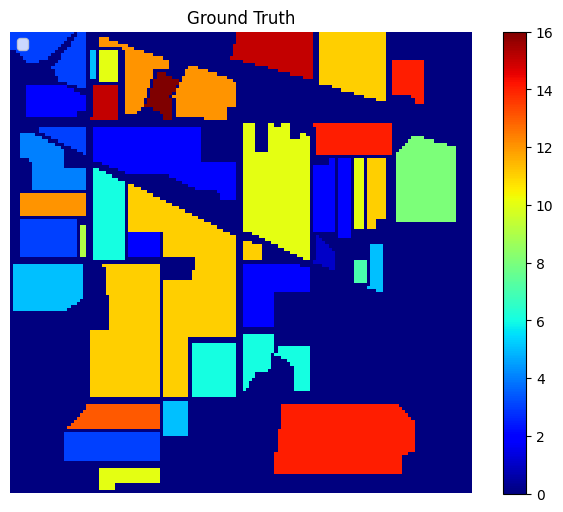

In [10]:
plt.figure(figsize=(8, 6))
plt.imshow(y, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title('Ground Truth')
plt.gca().legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10', '11', '12', '13', '14', '15', '16'], loc='upper left')
#plt.savefig('ground_truth.png')
plt.show()

In [11]:
print(y)

[[3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
X = X.reshape(X.shape[0]*X.shape[1], X.shape[2])

In [13]:
y = y.ravel()

In [14]:
label,counts=np.unique(y,return_counts=True)
print(label)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[10776    46  1428   830   237   483   730    28   478    20   972  2455
   593   205  1265   386    93]


In [15]:
from sklearn.preprocessing import StandardScaler
scaler_model = StandardScaler()
scaler_model.fit(X.astype(float))
X=scaler_model.transform(X)

In [16]:
print("X:", (X.shape))
print("y:", (y.shape))

X: (21025, 200)
y: (21025,)


In [17]:
X = (X[y>0,:])
Y = (y[y>0])

In [18]:
print("X:", (X.shape))
print("y:", (y.shape))

X: (10249, 200)
y: (21025,)


In [19]:
pca = PCA(n_components = 75)
X = pca.fit_transform(X)

In [20]:
np.cumsum(pca.explained_variance_ratio_)

array([0.68738846, 0.87307195, 0.90336774, 0.92106184, 0.93397519,
       0.9404841 , 0.94555385, 0.94971401, 0.95342082, 0.95677653,
       0.95947647, 0.96214806, 0.96447112, 0.96662825, 0.96869344,
       0.97052915, 0.97210577, 0.97363506, 0.97513317, 0.97647022,
       0.97772841, 0.97886063, 0.97996183, 0.98098477, 0.98193106,
       0.98279177, 0.98363225, 0.98442276, 0.98520169, 0.98597545,
       0.98669647, 0.98733939, 0.98793382, 0.98851366, 0.98906986,
       0.98959938, 0.99006071, 0.99050754, 0.99092868, 0.99131656,
       0.99166295, 0.99197705, 0.99228336, 0.9925768 , 0.99286327,
       0.99314129, 0.99340268, 0.99364768, 0.99388279, 0.99410434,
       0.99430744, 0.99450218, 0.994694  , 0.99487638, 0.99505414,
       0.99522542, 0.99539045, 0.99555229, 0.99571174, 0.9958554 ,
       0.9959957 , 0.99612694, 0.99625665, 0.99638311, 0.99650662,
       0.99662454, 0.99673598, 0.99684687, 0.99694985, 0.9970474 ,
       0.99714346, 0.99723284, 0.99731794, 0.99739974, 0.99748

75


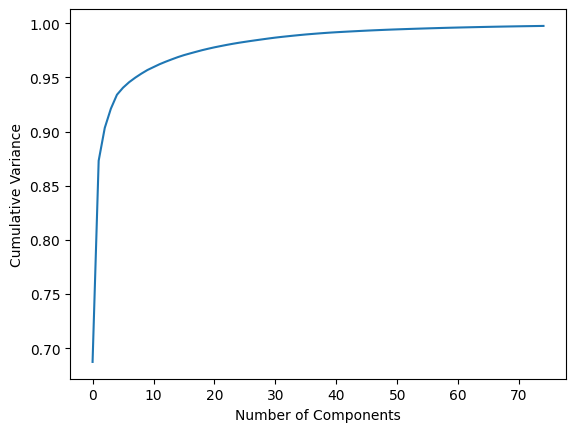

<Figure size 640x480 with 0 Axes>

In [23]:
print(pca.n_components_)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.savefig('indian_pines_explainedvariance_final')
plt.show()
plt.savefig('CVvsNP.png')